## Upsell 모델 remodeling

### 목적
- 최신 데이터 반영
 
### 모델링
- 기존과 동일한 feature, preprocessing

In [9]:
import lightgbm as lgb

import pandas as pd
import numpy as np
import pickle
import time
import shap
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive, send_query


from sm_utils import sampling, evaluate, save_model, load_model
from sm_utils import make_train_data,  make_test_data, df_to_md_table

In [10]:
DATA_PATH = '/home/dmig/work/upsell/data/'

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

def next_month(ym):
    next_month = datetime.strptime(ym, '%Y%m') + relativedelta(months=1)
    return datetime.strftime(next_month, '%Y%m')

### load data

In [13]:
df_mart08 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201908.pkl'))
df_mart07 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201907.pkl'))

In [14]:
df_mart08.shape, df_mart07.shape

((18681702, 81), (18612165, 81))

In [7]:
df_mart08.label.sum()/df_mart08.shape[0], df_mart07.label.sum()/df_mart07.shape[0], 

(0.020691369555086575, 0.02646167170772449)

## modeling

In [19]:
# make train data
result = make_train_data(df_mart08)

trn_idx = result['trn']['idx']
x_trn = result['trn']['x']
y_trn = result['trn']['y']

val_idx = result['val']['idx']
x_val = result['val']['x']
y_val = result['val']['y']

feature_cols = list(x_trn.columns)

lgb_trn = lgb.Dataset(x_trn, y_trn, feature_name=feature_cols)
lgb_val = lgb.Dataset(x_val, y_val, feature_name=feature_cols)

make_train_data +++
label/sample:  0.2
sample/total:  0.10345684777543288
make_data_for_modeling---


In [10]:
# best parameters
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'num_leaves': 32,
    'learning_rate': 0.05,
    'num_threads': 40,
}

In [11]:
t1 = time.time()
clf = lgb.train(lgb_params,
                train_set=lgb_trn,
                valid_sets=[lgb_trn, lgb_val],
                num_boost_round=5000,
                early_stopping_rounds=100,
                verbose_eval=50)
print('elapsed time:', time.time()-t1)

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.766622	valid_1's auc: 0.765936
[100]	training's auc: 0.777074	valid_1's auc: 0.77612
[150]	training's auc: 0.781615	valid_1's auc: 0.780293
[200]	training's auc: 0.784635	valid_1's auc: 0.782973
[250]	training's auc: 0.786672	valid_1's auc: 0.784612
[300]	training's auc: 0.78831	valid_1's auc: 0.785823
[350]	training's auc: 0.789352	valid_1's auc: 0.78635
[400]	training's auc: 0.790421	valid_1's auc: 0.786941
[450]	training's auc: 0.791409	valid_1's auc: 0.78744
[500]	training's auc: 0.792307	valid_1's auc: 0.787856
[550]	training's auc: 0.793145	valid_1's auc: 0.788163
[600]	training's auc: 0.793947	valid_1's auc: 0.788458
[650]	training's auc: 0.794774	valid_1's auc: 0.788745
[700]	training's auc: 0.795463	valid_1's auc: 0.788945
[750]	training's auc: 0.796117	valid_1's auc: 0.789095
[800]	training's auc: 0.79687	valid_1's auc: 0.789342
[850]	training's auc: 0.797531	valid_1's auc: 0.789509
[900]	tr

## evaluate

In [12]:
test_result = make_test_data(df_mart07)
x_test = test_result['x']
y_test = test_result['y']

        acc   recall  precision  f1_score      auc
0  0.658418  0.77521   0.057598  0.107229  0.78614
         pred: 1   pred: 0
true: 1   381798    110711
true: 0  6246865  11872791


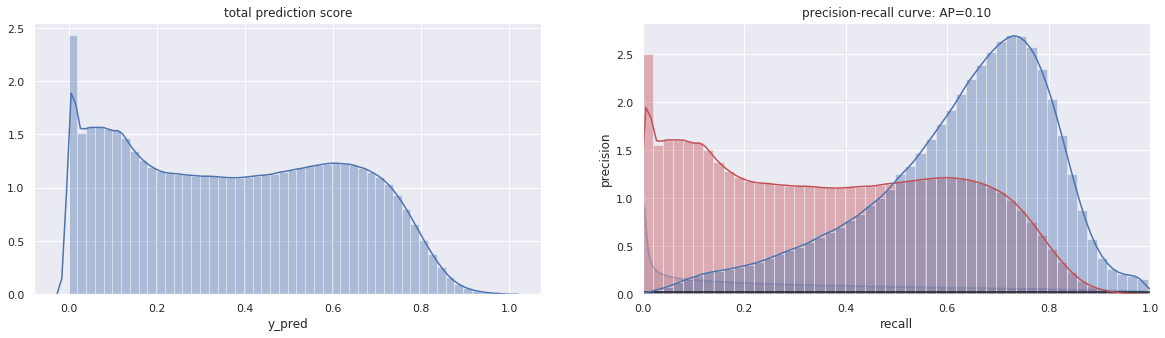

In [13]:
eval_result = evaluate(x_test[feature_cols], y_test.label.values, clf, clf_name='lgb')

## process for offline test

In [14]:
from item_reco_test_binary_post import OfflineTest4Binary

In [15]:
ot4b = OfflineTest4Binary(
    reco_type='upsell',
    test_ym='201907',
    model=clf,
    model_name='dominic_lgbm_08_20191011',
    feature_cols=clf.feature_name()
)

init +++
reco_type:  upsell
prod_id:  RC00000001
prod_nm:  요금제업셀가망
test_ym:  201907
model_name:  dominic_lgbm_08_20191011
feature_cols:  ['sex_cd', 'age', 'svc_gr', 'mng_nice_cb_scr', 'mng_nice_cb_grd', 'svc_scrb_period', 'last_equip_period', 'bas_fee_amt', 'bas_ofr_data_gb', 'eqp_out_prc', 'allot_prn_amt', 'pmth_inv_bamt', 'family_yn', 'family_small_yn', 'twld_visit_cnt_bf_m0', 'twld_visit_cnt_bf_m1', 'twld_visit_cnt_bf_m2', 'avg_twld_visit_cnt', 'twld_fee_visit_cnt_bf_m0', 'twld_fee_visit_cnt_bf_m1', 'twld_fee_visit_cnt_bf_m2', 'avg_twld_fee_visit_cnt', 'ansim_yn', 'ref_data_usage_in_gb_bf_m0', 'ref_data_usage_in_gb_bf_m1', 'ref_data_usage_in_gb_bf_m2', 'data_usage_in_gb_bf_m0', 'data_usage_in_gb_bf_m1', 'data_usage_in_gb_bf_m2', 'avg_data_usage_in_gb', 'overage_bf0', 'overage_bf1', 'overage_bf2', 'copn_data_u1_yn_bf_m0', 'copn_data_u1_yn_bf_m1', 'copn_data_u1_yn_bf_m2', 'data_gift_send_yn_bf_m0', 'data_gift_send_yn_bf_m1', 'data_gift_send_yn_bf_m2', 'data_gift_recv_yn_bf_m0', 'data_

In [16]:
ot4b.one_shot(df_mart07)

one_shot +++
submit_to_item_reco_test +++
load_to_comm_table +++
load to dumbo table +++
2019-10-11 07:22:59,170 - YE_HIVE - INFO - Query 'CREATE TABLE IF NOT EXISTS dumbo.item_reco_test_upsell (                        svc_mgmt_num string, prod_id string, prod_nm string, score double, reco_type string, model string, ym string )                        row format delimited
fields terminated by '\t' stored as textfile' is done
2019-10-11 07:22:59,193 - YE_HIVE - INFO - save dataframe for textfile format... 
2019-10-11 07:24:32,819 - YE_HIVE - INFO - Loading data to HDFS... 
2019-10-11 07:24:51,799 - YE_HIVE - INFO - Loading to table dumbo.item_reco_test_upsell is done
insert to comm table +++
2019-10-11 07:25:08,057 - YE_HIVE - INFO - Query '
            INSERT  OVERWRITE TABLE comm.item_reco_test PARTITION (reco_type, model, ym)
            SELECT  *
            FROM    dumbo.item_reco_test_upsell
        ' is done
drop dumbo table +++
2019-10-11 07:25:08,711 - YE_HIVE - INFO - Query 'dr

## Interpretable ML
- 서비스 나갈만한 모델인가?
- 모델이 어떤 특성으로 회선들을 예측하는지 이해해보자
- 그 방식이 resonable 한가?
    - 이상하다면?? -> todo_list를 만들고 추후에 변경

## How? & What?

1. Global interpretability
    - 전체적으로 봤을 때, 각각의 feature가 model output에 얼마나 영향을 미치는지? -> feature importance
    ex) 비싼 요금제를 쓰는 고객들이 5g 단말기를 사는 경향이 있다
2. Local interpretability
    - 개별 data point에 대한 model output 산출 이유
    ex) 해당 고객이 5g 단말기 살 가능성이 높은 이유는, '가입한지 2년이 됐고 이전 요금제가 비싸고 옥수수에 가입했기 때문'이다.



### model feature importance

In [17]:
pd.DataFrame({'feature': clf.feature_name(), 'importance': clf.feature_importance()}).sort_values('importance', ascending=False).head(50)

feature  importance
6            last_equip_period        6210
1                          age        5903
5              svc_scrb_period        4569
53            data_usage_ratio        4112
44     avg_subscription_period        3983
3              mng_nice_cb_scr        3952
46             real_arpu_bf_m1        3550
45            avg_chg_duration        3499
7                  bas_fee_amt        3416
54  bf_m6_data_usage_ratio_avg        3313
26      data_usage_in_gb_bf_m0        2957
47             real_arpu_bf_m2        2847
28      data_usage_in_gb_bf_m2        2654
10               allot_prn_amt        2649
27      data_usage_in_gb_bf_m1        2528
49               real_avg_arpu        2490
11               pmth_inv_bamt        2395
8              bas_ofr_data_gb        2355
51  bf_m6_sum_data_usage_in_gb        2098
29        avg_data_usage_in_gb        2057
52  bf_m6_avg_data_usage_in_gb        1807
43             avg_mbr_use_cnt        1534
78                     channel        1013
50           bf_m3_fee_chg_cnt         870
57           copn_left_cnt_bf0         827
30                 overage_bf0         805
4              mng_nice_cb_grd         710
59           copn_left_cnt_bf2         702
12                   family_yn         686
32                 overage_bf2         673
31                 overage_bf1         595
58           copn_left_cnt_bf1         589
55   bf_m6_data_over_usage_cnt         558
0                       sex_cd         547
69          mth_cnsl_cnt_bf_m0         539
17          avg_twld_visit_cnt         521
2                       svc_gr         475
71          mth_cnsl_cnt_bf_m2         444
25  ref_data_usage_in_gb_bf_m2         413
75    simpl_ref_cnsl_cnt_bf_m0         384
16        twld_visit_cnt_bf_m2         358
70          mth_cnsl_cnt_bf_m1         348
77    simpl_ref_cnsl_cnt_bf_m2         298
15        twld_visit_cnt_bf_m1         296
13             family_small_yn         284
76    simpl_ref_cnsl_cnt_bf_m1         271
42                  sec_dev_yn         259
22                    ansim_yn         250
56   bf_m3_data_over_usage_cnt         232
39     data_gift_recv_yn_bf_m0         209

- top 20 살펴보기
- label 별 분포

In [18]:
top20_cols = list(pd.DataFrame({'feature': clf.feature_name(), 'importance': clf.feature_importance()}).sort_values('importance', ascending=False).head(20).feature)

In [19]:
from eda_tools import numeric_eda_plot, categorical_eda_plot

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LABEL COUNTS : {0: 100000, 1: 100000}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



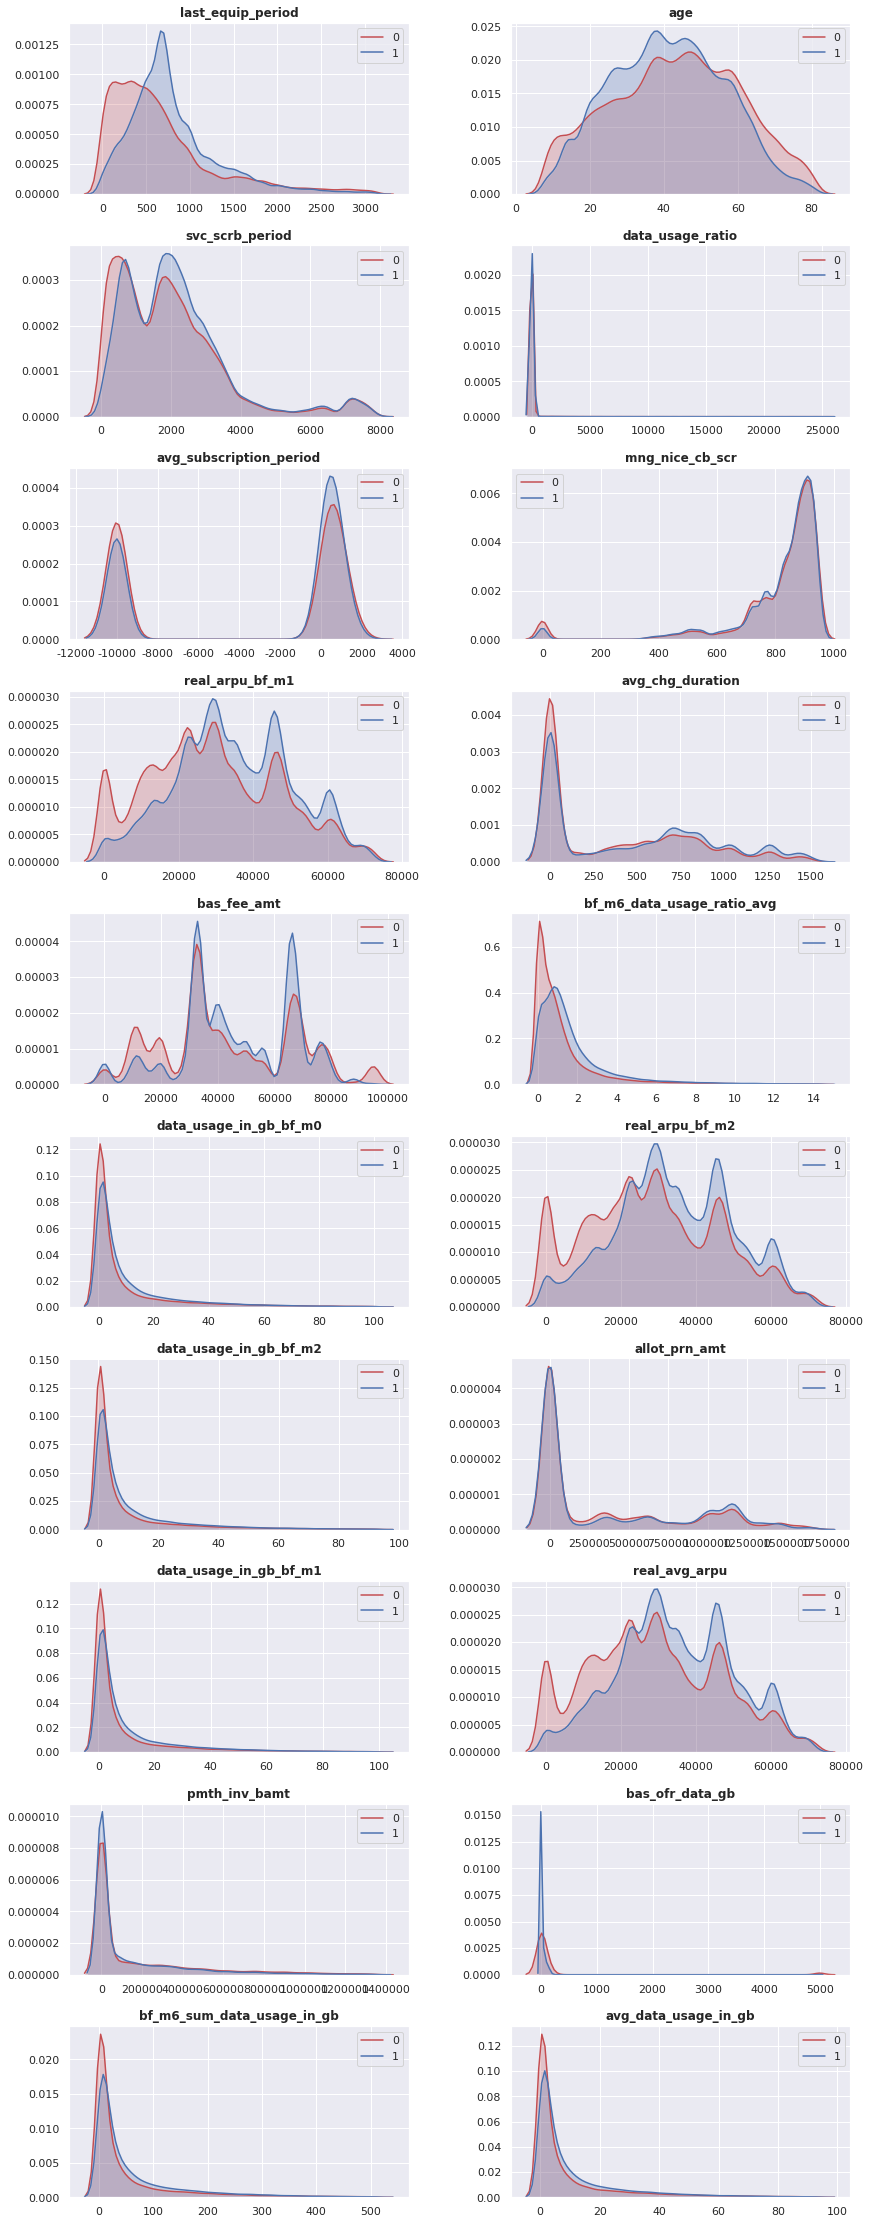

In [20]:
numeric_eda_plot(df_mart08, top20_cols, 'label', n_samples=100000)

In [126]:
for col in top20_cols:
    if col in ['age', 'avg_chg_duration', 'avg_subscription_period', 'allot_prn_amt', 'pmth_inv_bamt']:
        continue
    print('='*50)
    print('col: ', col)
    print('label ratio: ', df_mart07_new[df_mart07_new[col]==0].label.sum()/df_mart07_new[df_mart07_new[col]==0].shape[0])
    print('cnt: ', df_mart07_new[df_mart07_new[col]==0].shape[0])
    
    zero_dict[col] = list(df_mart07_new[df_mart07_new[col]==0].svc_mgmt_num.values)

col:  last_equip_period
label ratio:  0.007892997394922042
cnt:  25719
col:  svc_scrb_period
label ratio:  0.011572114027660174
cnt:  10629
col:  mng_nice_cb_scr
label ratio:  0.009375046688479525
cnt:  133866
col:  data_usage_ratio
label ratio:  0.009066056228212653
cnt:  2143159
col:  bas_fee_amt
label ratio:  0.017241379310344827
cnt:  58
col:  bf_m6_data_usage_ratio_avg
label ratio:  0.008479918731110207
cnt:  1943179
col:  real_arpu_bf_m1
label ratio:  0.005146029413803141
cnt:  577144
col:  bas_ofr_data_gb
label ratio:  nan
cnt:  0
col:  real_arpu_bf_m3
label ratio:  0.0058829192824963236
cnt:  903633
col:  data_usage_in_gb_bf_m0
label ratio:  0.009066056228212653
cnt:  2143159
col:  real_arpu_bf_m2
label ratio:  0.00567439301189903
cnt:  726950
col:  data_usage_in_gb_bf_m1
label ratio:  0.009263414031843739
cnt:  2324413
col:  data_usage_in_gb_bf_m2
label ratio:  0.00893543121833965
cnt:  2509448
col:  real_avg_arpu
label ratio:  0.004809306276580552
cnt:  539163
col:  avg_data_

### 해석
- 데이터 관련 feature가 0인 회선이 상당히 많음 -> 250만
- 대부분이 신규 고객
- 그런데 아닌 고객들도 있음 -> 확인 필요
- + 맞춤형, 함께쓰기 요금제 외에도 bas_ofr_data_gb 값이 0인 요금제가 있음 -> 뉴실버, 팅 등 

In [172]:
"""
select b.prod_id, b.prod_nm, count(1)
from comm.mmkt_svc_bas_f a
left join (
    SELECT  prod_id
    ,       prod_nm
    ,       if(bas_ofr_data_qty_val = '#', cast(bas_ofr_data_gb_qty_val as double), cast(bas_ofr_data_qty_val as int)/1024) as bas_ofr_data_gb_qty_val 
    from    comm.td_zprd_prod
    where   svc_prod_cd = 1 
) b on a.fee_prod_id = b.prod_id
where a.ym = '201907'
and b.bas_ofr_data_gb_qty_val is null
and prod_nm not like '%함께쓰기%' 
and prod_nm not like '%맞춤형%'
and fee_prod_id not in ('NA00006405','NA00006404','NA00006539','NA00003128','NA00002502','NA00005959',
                        'NA00003127','NA00002501','NA00003126','NA00002708','NA00003125','NA00002500','NA00002997')
group by b.prod_id, b.prod_nm
;
"""

"\nselect b.prod_id, b.prod_nm, count(1)\nfrom comm.mmkt_svc_bas_f a\nleft join (\n    SELECT  prod_id\n    ,       prod_nm\n    ,       if(bas_ofr_data_qty_val = '#', cast(bas_ofr_data_gb_qty_val as double), cast(bas_ofr_data_qty_val as int)/1024) as bas_ofr_data_gb_qty_val \n    from    comm.td_zprd_prod\n    where   svc_prod_cd = 1 \n) b on a.fee_prod_id = b.prod_id\nwhere a.ym = '201907'\nand b.bas_ofr_data_gb_qty_val is null\nand prod_nm not like '%함께쓰기%' \nand prod_nm not like '%맞춤형%'\nand fee_prod_id not in ('NA00006405','NA00006404','NA00006539','NA00003128','NA00002502','NA00005959',\n                        'NA00003127','NA00002501','NA00003126','NA00002708','NA00003125','NA00002500','NA00002997')\ngroup by b.prod_id, b.prod_nm\n;\n"

## shap value

In [25]:
from shap_tools import ShapModule

In [26]:
feature_cols

['sex_cd',
 'age',
 'svc_gr',
 'mng_nice_cb_scr',
 'mng_nice_cb_grd',
 'svc_scrb_period',
 'last_equip_period',
 'bas_fee_amt',
 'bas_ofr_data_gb',
 'eqp_out_prc',
 'allot_prn_amt',
 'pmth_inv_bamt',
 'family_yn',
 'family_small_yn',
 'twld_visit_cnt_bf_m0',
 'twld_visit_cnt_bf_m1',
 'twld_visit_cnt_bf_m2',
 'avg_twld_visit_cnt',
 'twld_fee_visit_cnt_bf_m0',
 'twld_fee_visit_cnt_bf_m1',
 'twld_fee_visit_cnt_bf_m2',
 'avg_twld_fee_visit_cnt',
 'ansim_yn',
 'ref_data_usage_in_gb_bf_m0',
 'ref_data_usage_in_gb_bf_m1',
 'ref_data_usage_in_gb_bf_m2',
 'data_usage_in_gb_bf_m0',
 'data_usage_in_gb_bf_m1',
 'data_usage_in_gb_bf_m2',
 'avg_data_usage_in_gb',
 'overage_bf0',
 'overage_bf1',
 'overage_bf2',
 'copn_data_u1_yn_bf_m0',
 'copn_data_u1_yn_bf_m1',
 'copn_data_u1_yn_bf_m2',
 'data_gift_send_yn_bf_m0',
 'data_gift_send_yn_bf_m1',
 'data_gift_send_yn_bf_m2',
 'data_gift_recv_yn_bf_m0',
 'data_gift_recv_yn_bf_m1',
 'data_gift_recv_yn_bf_m2',
 'sec_dev_yn',
 'avg_mbr_use_cnt',
 'avg_subscription_period',
 'avg_chg_duration',
 'real_arpu_bf_m1',
 'real_arpu_bf_m2',
 'real_arpu_bf_m3',
 'real_avg_arpu',
 'bf_m3_fee_chg_cnt',
 'bf_m6_sum_data_usage_in_gb',
 'bf_m6_avg_data_usage_in_gb',
 'data_usage_ratio',
 'bf_m6_data_usage_ratio_avg',
 'bf_m6_data_over_usage_cnt',
 'bf_m3_data_over_usage_cnt',
 'copn_left_cnt_bf0',
 'copn_left_cnt_bf1',
 'copn_left_cnt_bf2',
 'overage_5k_3m',
 'overage_5k_3m_or',
 'overage_inc_3m',
 'refill_0_yn',
 'ref_data_use_3m',
 'gift_recv_3m',
 'data_incr_3m',
 'tw_spd_chk_1m',
 'tw_tplan_chk_1m',
 'mth_cnsl_cnt_bf_m0',
 'mth_cnsl_cnt_bf_m1',
 'mth_cnsl_cnt_bf_m2',
 'dsat_cnsl_cnt_bf_m0',
 'dsat_cnsl_cnt_bf_m1',
 'dsat_cnsl_cnt_bf_m2',
 'simpl_ref_cnsl_cnt_bf_m0',
 'simpl_ref_cnsl_cnt_bf_m1',
 'simpl_ref_cnsl_cnt_bf_m2',
 'channel']

In [27]:
df_mart08.shape

(18681702, 81)

In [28]:
sm = ShapModule(df_mart08, clf, feature_cols, 'svc_mgmt_num', 'label')

In [22]:
sm.calculate_shap_value()

ValueError: Must pass 2-d input

In [ ]:
top20_cols

In [ ]:
sm.summary_plot(max_display=20)

- allot_prn_amt, sex_cd, family_yn, mth_cnsl_cnt_bf_m0, avg_mbr_use_cnt, sexc_dev_yn 등이 model feature importance와 다름
- categorical feature가 더 있는 점이 흥미로움

In [56]:
svc_mgmt_num = '1032341110'
single_shap_value = sm.explainer.shap_values(sm.df[sm.feature_cols].loc[[svc_mgmt_num], :])
shap.force_plot(sm.explainer.expected_value, single_shap_value, 
                df_mart07_new[df_mart07_new['svc_mgmt_num']==svc_mgmt_num][sm.feature_cols], sm.feature_cols, out_names=str(svc_mgmt_num))

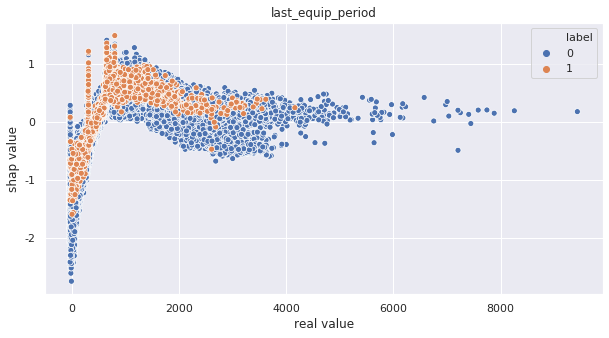

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LABEL COUNTS : {0: 97354, 1: 2645}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



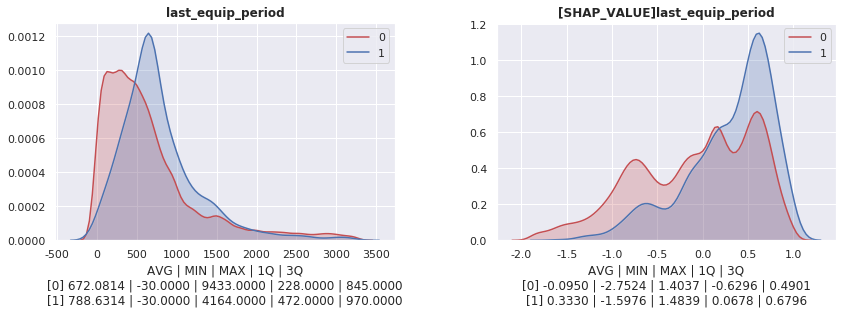

In [35]:
sm.real_vs_shap_scatter_plot('last_equip_period')

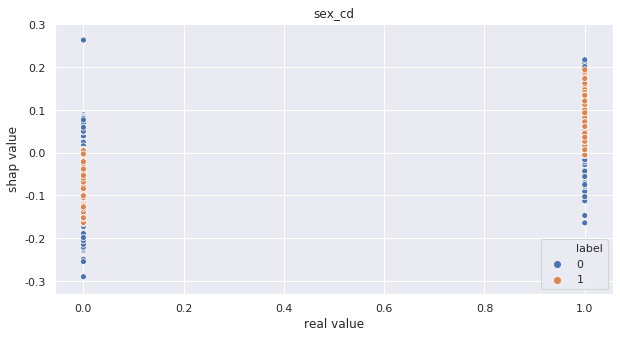

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LABEL COUNTS : {0: 97354, 1: 2645}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



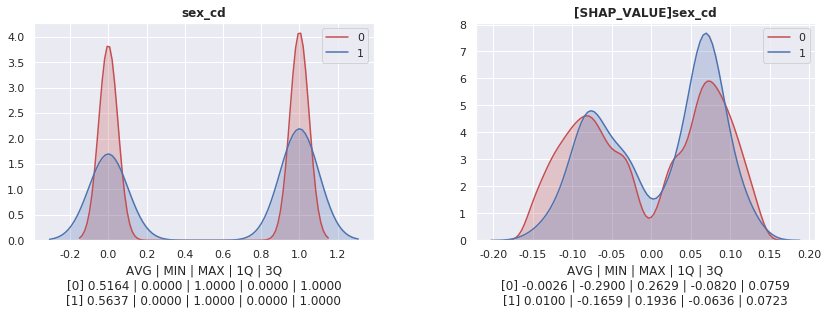

In [154]:
sm.real_vs_shap_scatter_plot('sex_cd')

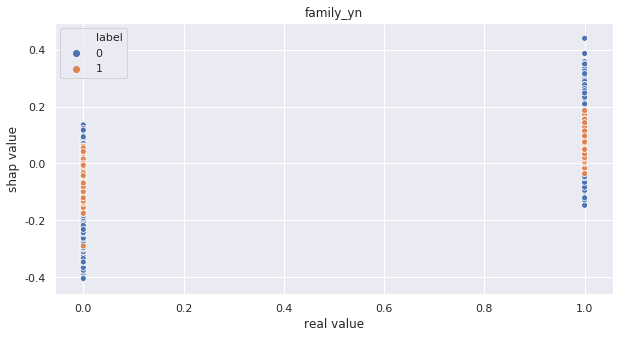

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LABEL COUNTS : {0: 97354, 1: 2645}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



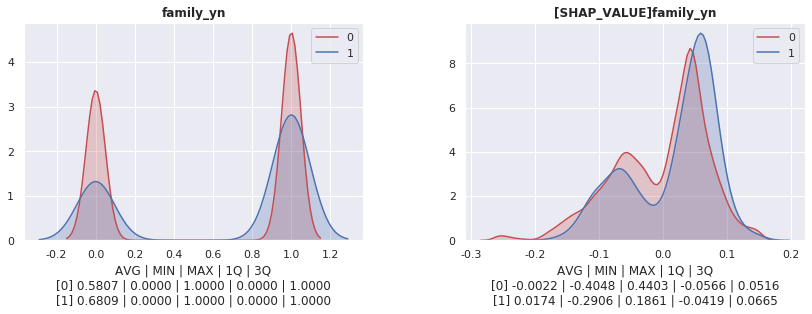

In [155]:
sm.real_vs_shap_scatter_plot('family_yn')

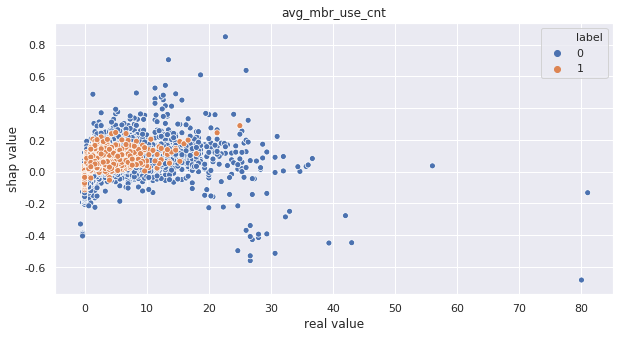

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LABEL COUNTS : {0: 97354, 1: 2645}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



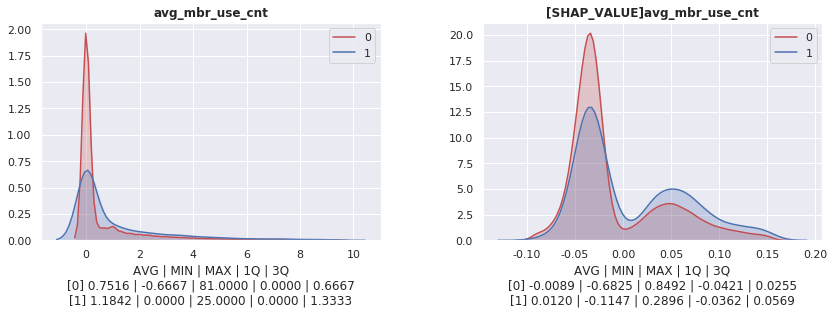

In [156]:
sm.real_vs_shap_scatter_plot('avg_mbr_use_cnt')

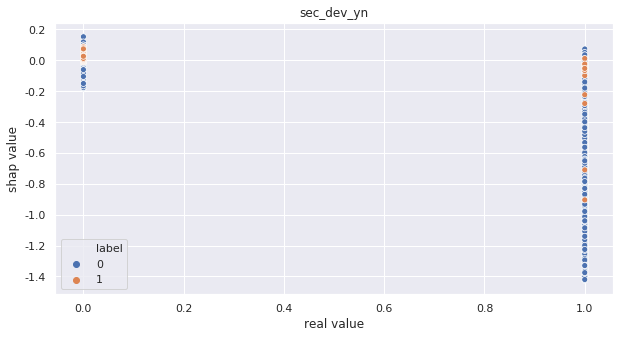

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
LABEL COUNTS : {0: 97354, 1: 2645}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



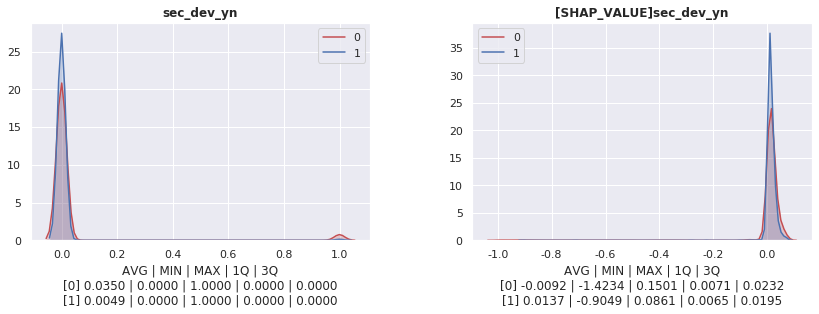

In [158]:
sm.real_vs_shap_scatter_plot('sec_dev_yn')

Confusion matrix


Pred:True  Pred:False
Actual:True           0           0
Actual:False          0           0

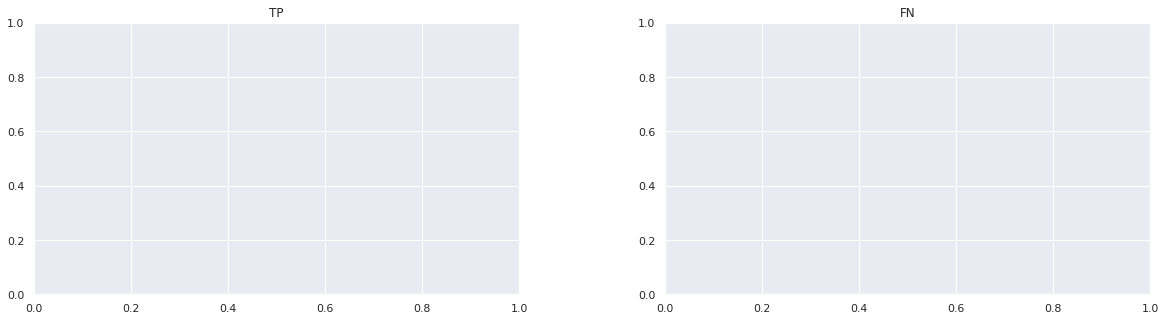

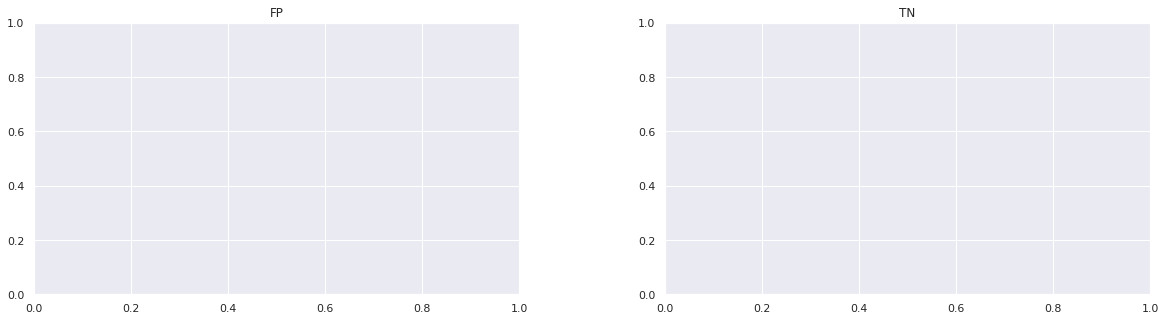

In [160]:
sm.summary_plot_for_confusion_matrix()

## 9월 데이터를 이용해서 prediction

In [23]:
df_mart09 = pd.read_pickle('/home/dmig/work/upsell/data/df_input_201909.pkl')
df_mart09.shape

(18949210, 80)

In [24]:
df_score = df_mart09[['svc_mgmt_num']]

In [25]:
df_score['score'] = clf.predict(df_mart09[feature_cols])

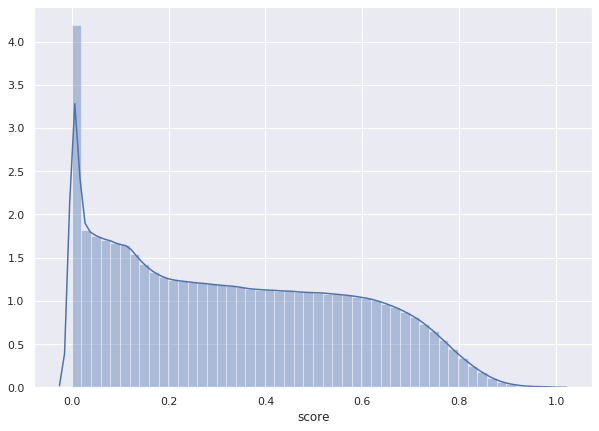

In [26]:
import seaborn as sns

sns.distplot(df_score['score'])

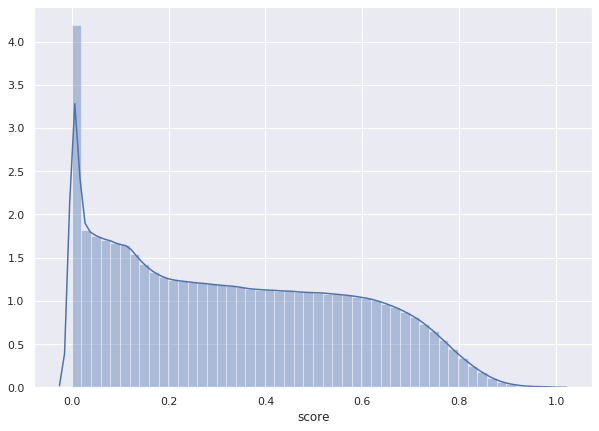

In [27]:
import seaborn as sns

sns.distplot(df_score['score'])

In [28]:
df_score['prod_id'] = 'RC00000001'
df_score['prod_nm'] = '요금제업셀가망'
df_score['score'] = np.round(df_score.score, 4)
df_score['reco_type'] = 'upsell'
df_score['model'] = 'dominic_lgbm_20191011'
df_score['dt'] = '20191011'

In [29]:
df_score.sort_values('score').head(20)

svc_mgmt_num  score     prod_id  prod_nm reco_type  \
41272   7051904346    0.0  RC00000001  요금제업셀가망    upsell   
48308   7261255797    0.0  RC00000001  요금제업셀가망    upsell   
47422   7259425047    0.0  RC00000001  요금제업셀가망    upsell   
56131   1085083802    0.0  RC00000001  요금제업셀가망    upsell   
50682   7276309101    0.0  RC00000001  요금제업셀가망    upsell   
83427   7253283202    0.0  RC00000001  요금제업셀가망    upsell   
50709   7276401028    0.0  RC00000001  요금제업셀가망    upsell   
56223   1163307915    0.0  RC00000001  요금제업셀가망    upsell   
50764   7276723147    0.0  RC00000001  요금제업셀가망    upsell   
82966   7241270671    0.0  RC00000001  요금제업셀가망    upsell   
50792   7276866555    0.0  RC00000001  요금제업셀가망    upsell   
64871   7246452645    0.0  RC00000001  요금제업셀가망    upsell   
7109    7238233669    0.0  RC00000001  요금제업셀가망    upsell   
82980   7241357860    0.0  RC00000001  요금제업셀가망    upsell   
66471   7253783052    0.0  RC00000001  요금제업셀가망    upsell   
25896   7236251139    0.0  RC00000001  요금제업셀가망    upsell   
57520   7014305747    0.0  RC00000001  요금제업셀가망    upsell   
58648   7010089541    0.0  RC00000001  요금제업셀가망    upsell   
78685   7039998964    0.0  RC00000001  요금제업셀가망    upsell   
37093   7307184393    0.0  RC00000001  요금제업셀가망    upsell   

                       model        dt  
41272  dominic_lgbm_20191011  20191011  
48308  dominic_lgbm_20191011  20191011  
47422  dominic_lgbm_20191011  20191011  
56131  dominic_lgbm_20191011  20191011  
50682  dominic_lgbm_20191011  20191011  
83427  dominic_lgbm_20191011  20191011  
50709  dominic_lgbm_20191011  20191011  
56223  dominic_lgbm_20191011  20191011  
50764  dominic_lgbm_20191011  20191011  
82966  dominic_lgbm_20191011  20191011  
50792  dominic_lgbm_20191011  20191011  
64871  dominic_lgbm_20191011  20191011  
7109   dominic_lgbm_20191011  20191011  
82980  dominic_lgbm_20191011  20191011  
66471  dominic_lgbm_20191011  20191011  
25896  dominic_lgbm_20191011  20191011  
57520  dominic_lgbm_20191011  20191011  
58648  dominic_lgbm_20191011  20191011  
78685  dominic_lgbm_20191011  20191011  
37093  dominic_lgbm_20191011  20191011

In [32]:
conn = hive_connection('dmig')
send_query(conn, 'drop table dumbo.item_reco_predict_dominic')

2019-10-11 08:08:12,659 - YE_HIVE - INFO - Query 'drop table dumbo.item_reco_predict_dominic' is done


In [33]:
conn = hive_connection('dmig')
load_to_hive(conn, 
             df_score[['svc_mgmt_num', 'prod_id', 'prod_nm', 'score', 'reco_type', 'model', 'dt']], 
             'dumbo.item_reco_predict_dominic')

2019-10-11 08:08:14,776 - YE_HIVE - INFO - Query 'CREATE TABLE IF NOT EXISTS dumbo.item_reco_predict_dominic (                        svc_mgmt_num string, prod_id string, prod_nm string, score double, reco_type string, model string, dt string )                        row format delimited
fields terminated by '\t' stored as textfile' is done
2019-10-11 08:08:14,793 - YE_HIVE - INFO - save dataframe for textfile format... 
2019-10-11 08:09:53,038 - YE_HIVE - INFO - Loading data to HDFS... 
2019-10-11 08:10:12,442 - YE_HIVE - INFO - Loading to table dumbo.item_reco_predict_dominic is done


## check 후 insert

In [37]:
insert_sql = """
INSERT  OVERWRITE TABLE comm_dev.item_reco_predict PARTITION (reco_type, model, dt)
SELECT  *
FROM    dumbo.item_reco_predict_dominic
"""

In [38]:
conn = hive_connection('dmig')
send_query(conn, insert_sql)

2019-10-11 08:52:54,908 - YE_HIVE - INFO - Query '
INSERT  OVERWRITE TABLE comm_dev.item_reco_predict PARTITION (reco_type, model, dt)
SELECT  *
FROM    dumbo.item_reco_predict_dominic
' is done


In [36]:
save_model(clf, 'dominic_lgbm_20191011')

save model to  /home/dmig/work/upsell/model/dominic_lgbm_20191011


In [2]:
clf= load_model('dominic_lgbm_20191011')

load model from  dominic_lgbm_20191011


In [8]:
pd.DataFrame({'feature': clf.feature_name(), 
             'importance': clf.feature_importance()}).sort_values('importance').head(50)

feature  importance
48             real_arpu_bf_m3           0
24  ref_data_usage_in_gb_bf_m1           0
23  ref_data_usage_in_gb_bf_m0           0
20    twld_fee_visit_cnt_bf_m2           0
18    twld_fee_visit_cnt_bf_m0           0
9                  eqp_out_prc           0
68             tw_tplan_chk_1m           0
19    twld_fee_visit_cnt_bf_m1           1
62              overage_inc_3m          22
21      avg_twld_fee_visit_cnt          22
67               tw_spd_chk_1m          22
60               overage_5k_3m          25
74         dsat_cnsl_cnt_bf_m2          39
64             ref_data_use_3m          62
73         dsat_cnsl_cnt_bf_m1          72
63                 refill_0_yn          77
65                gift_recv_3m          78
72         dsat_cnsl_cnt_bf_m0          78
35       copn_data_u1_yn_bf_m2          81
34       copn_data_u1_yn_bf_m1          96
41     data_gift_recv_yn_bf_m2         101
61            overage_5k_3m_or         114
40     data_gift_recv_yn_bf_m1         118
66                data_incr_3m         121
37     data_gift_send_yn_bf_m1         131
38     data_gift_send_yn_bf_m2         146
33       copn_data_u1_yn_bf_m0         189
14        twld_visit_cnt_bf_m0         189
36     data_gift_send_yn_bf_m0         199
39     data_gift_recv_yn_bf_m0         209
56   bf_m3_data_over_usage_cnt         232
22                    ansim_yn         250
42                  sec_dev_yn         259
76    simpl_ref_cnsl_cnt_bf_m1         271
13             family_small_yn         284
15        twld_visit_cnt_bf_m1         296
77    simpl_ref_cnsl_cnt_bf_m2         298
70          mth_cnsl_cnt_bf_m1         348
16        twld_visit_cnt_bf_m2         358
75    simpl_ref_cnsl_cnt_bf_m0         384
25  ref_data_usage_in_gb_bf_m2         413
71          mth_cnsl_cnt_bf_m2         444
2                       svc_gr         475
17          avg_twld_visit_cnt         521
69          mth_cnsl_cnt_bf_m0         539
0                       sex_cd         547
55   bf_m6_data_over_usage_cnt         558
58           copn_left_cnt_bf1         589
31                 overage_bf1         595
32                 overage_bf2         673

In [7]:
pd.DataFrame({'feature': clf.feature_name(), 
             'importance': clf.feature_importance()}).sort_values('importance', ascending=False).head(50)

feature  importance
6            last_equip_period        6210
1                          age        5903
5              svc_scrb_period        4569
53            data_usage_ratio        4112
44     avg_subscription_period        3983
3              mng_nice_cb_scr        3952
46             real_arpu_bf_m1        3550
45            avg_chg_duration        3499
7                  bas_fee_amt        3416
54  bf_m6_data_usage_ratio_avg        3313
26      data_usage_in_gb_bf_m0        2957
47             real_arpu_bf_m2        2847
28      data_usage_in_gb_bf_m2        2654
10               allot_prn_amt        2649
27      data_usage_in_gb_bf_m1        2528
49               real_avg_arpu        2490
11               pmth_inv_bamt        2395
8              bas_ofr_data_gb        2355
51  bf_m6_sum_data_usage_in_gb        2098
29        avg_data_usage_in_gb        2057
52  bf_m6_avg_data_usage_in_gb        1807
43             avg_mbr_use_cnt        1534
78                     channel        1013
50           bf_m3_fee_chg_cnt         870
57           copn_left_cnt_bf0         827
30                 overage_bf0         805
4              mng_nice_cb_grd         710
59           copn_left_cnt_bf2         702
12                   family_yn         686
32                 overage_bf2         673
31                 overage_bf1         595
58           copn_left_cnt_bf1         589
55   bf_m6_data_over_usage_cnt         558
0                       sex_cd         547
69          mth_cnsl_cnt_bf_m0         539
17          avg_twld_visit_cnt         521
2                       svc_gr         475
71          mth_cnsl_cnt_bf_m2         444
25  ref_data_usage_in_gb_bf_m2         413
75    simpl_ref_cnsl_cnt_bf_m0         384
16        twld_visit_cnt_bf_m2         358
70          mth_cnsl_cnt_bf_m1         348
77    simpl_ref_cnsl_cnt_bf_m2         298
15        twld_visit_cnt_bf_m1         296
13             family_small_yn         284
76    simpl_ref_cnsl_cnt_bf_m1         271
42                  sec_dev_yn         259
22                    ansim_yn         250
56   bf_m3_data_over_usage_cnt         232
39     data_gift_recv_yn_bf_m0         209